In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
# google drive mount

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import pandas as pd

data = pd.read_csv('/gdrive/My Drive/KoBERT/data/data_final.csv')

In [ ]:
# 결측치 확인

print(f"null 확인:\n{data.isnull().sum()}")

null 확인:
sentence    0
emotion     0
dtype: int64


In [ ]:
# 클래스 분포 확인

data.emotion.value_counts()

화남     9612
괴로움    8096
기쁨     7572
우울함    7234
긴장됨    5526
비참함    5355
놀람     3163
중립     2115
피로함    1770
지루함     797
Name: emotion, dtype: int64

In [ ]:
# 화남, 괴로움 -> 7500개 즈음으로 undersampling (삭제)

drop_upset_index = data[data.emotion == '화남'].sample(n=2000, random_state=0).index
drop_distressed_index = data[data.emotion == '괴로움'].sample(n=500, random_state=0).index

dataset = data.drop(drop_upset_index, axis=0)
dataset = dataset.drop(drop_distressed_index, axis=0)

In [ ]:
# 피로함, 지루함 -> 피로함으로 합치기

dataset.loc[dataset['emotion'] == '지루함', 'emotion'] = '피로함'

In [ ]:
dataset.emotion.value_counts()

화남     7612
괴로움    7596
기쁨     7572
우울함    7234
긴장됨    5526
비참함    5355
놀람     3163
피로함    2567
중립     2115
Name: emotion, dtype: int64

In [ ]:
# 한국어 아닌 데이터 제거

import re
from tqdm import tqdm

def removing_non_korean(df):
    for idx, row in tqdm(df.iterrows(), desc='removing_non_korean', total=len(df)):
        new_doc = re.sub('[^가-힣]', '', row['sentence']).strip()
        df.loc[idx, 'sentence'] = new_doc
    return df

dataset = removing_non_korean(dataset)

removing_non_korean: 100%|██████████| 48740/48740 [00:15<00:00, 3118.42it/s]


In [ ]:
# 여기까지 저장
dataset.to_csv('/gdrive/My Drive/KoBERT/data/data_1.csv', index=False)

In [ ]:
# 오탈자 교정

from hanspell import spell_checker

def spell_checking(df):
    for idx, row in tqdm(df.iterrows(), desc='spell_checking', total=len(df)):
        spelled_sent = spell_checker.check(row['sentence'])
        s_spell = spelled_sent.checked
        df.loc[idx, 'sentence'] = s_spell
    return df

dataset = spell_checking(dataset)

spell_checking: 100%|██████████| 48740/48740 [1:24:30<00:00,  9.61it/s]


In [ ]:
dataset

NameError: ignored

In [ ]:
# 여기까지 저장
dataset.to_csv('/gdrive/My Drive/KoBERT/data/data_2.csv', index=False)

In [ ]:
import pandas as pd

dataset = pd.read_csv('/gdrive/My Drive/KoBERT/data/data_2.csv')
dataset

,sentence,emotion
0,제 감정이 이상해진 것 같아요 남편만 보면 화가 치밀어 오르고 감정 조절이 안돼요,화남
1,더 이상 내 감정을 내가 컨트롤 못하겠어,비참함
2,하루 종일 오르락내리락 롤러코스터 타는 기분이에요,비참함
3,꼭 롤러코스터 타는 것 같아요,긴장됨
4,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요,우울함
...,...,...
48735,학교 친구들이 나만 계속 따돌려서 너무 무서워,화남
48736,부동산임대소득으로 현재 여유롭게 살 수 있어서 좋단다,기쁨
48737,폐결핵은 이미 완치된 것 같은데 약을 한 달이나 더 먹으라고 하네 아직 안 나은 게...,피로함
48738,연애하고 싶은데 소개팅만 나가면 꽝이야 이러다가 난 결혼 못 하고 늙어 죽을 거야,비참함


In [ ]:
from kobert.pytorch_kobert import get_pytorch_kobert_model
from kobert import get_tokenizer
import gluonnlp as nlp

bertmodel, vocab = get_pytorch_kobert_model()

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# konlpy, Mecab 형태소 분석기 설치 스크립트 실행
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

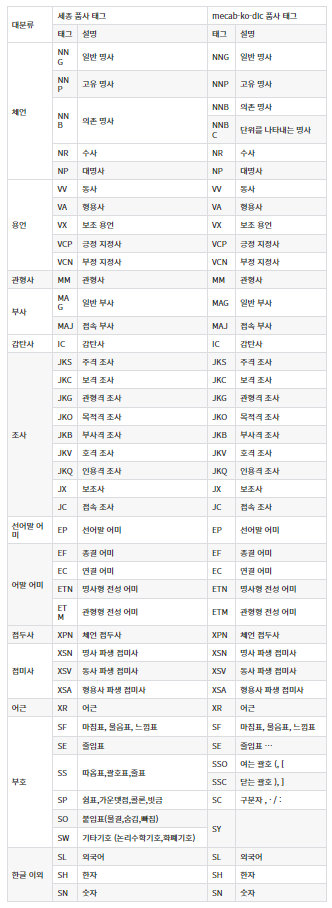

In [ ]:
# 형태소 분석 - 조사와 어미 제거

from konlpy.tag import Mecab

m = Mecab()
# remove_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM']
remove_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'ETN', 'ETM']

def remove_mecab(df, tags):
    for idx, row in tqdm(df.iterrows(), desc='removing', total=len(df)):
        removed = [x[0] for x in m.pos(row['sentence']) if x[1] not in remove_tags]
        df.loc[idx, 'sentence'] = ' '.join(removed)
    return df

dataset_mecab = remove_mecab(dataset, remove_tags)

removing: 100%|██████████| 48740/48740 [00:17<00:00, 2829.77it/s]


In [ ]:
dataset_mecab

,sentence,emotion
0,제 감정 이상 해진 것 같 남편 보 면 화 치밀 어 오르 고 감정 조절 안 되 요,화남
1,더 이상 내 감정 내 컨트롤 못 하 어,비참함
2,하루 종일 오르락내리락 롤러코스터 타 기분 이,비참함
3,꼭 롤러코스터 타 것 같 아요,긴장됨
4,롤러코스터 타 것 기분 왔 다 갔 다 해요,우울함
...,...,...
51234,학교 친구 들 나 계속 따돌려 서 너무 무서워,화남
51235,부동산 임대 소득 현재 여유 롭 게 살 수 있 어서 좋 단다,기쁨
51236,폐결핵 이미 완치 된 것 같 은데 약 한 달 더 먹 으라고 하 아직 안 나 게 아닌...,피로함
51237,연애 하 고 싶 은데 소개팅 나가 면 꽝 이 야 이러 다가 난 결혼 못 하 고 늙 ...,비참함


In [ ]:
print(f"null 확인:\n{dataset_mecab.isnull().sum()}")

null 확인:
sentence    0
emotion     0
dtype: int64


In [ ]:
# 감정 라벨링

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(dataset_mecab['emotion'])
dataset_mecab['emotion'] = encoder.transform(dataset_mecab['emotion'])
dataset_mecab

,sentence,emotion
0,제 감정 이상 해진 것 같 남편 보 면 화 치밀 어 오르 고 감정 조절 안 되 요,8
1,더 이상 내 감정 내 컨트롤 못 하 어,4
2,하루 종일 오르락내리락 롤러코스터 타 기분 이,4
3,꼭 롤러코스터 타 것 같 아요,2
4,롤러코스터 타 것 기분 왔 다 갔 다 해요,5
...,...,...
51234,학교 친구 들 나 계속 따돌려 서 너무 무서워,8
51235,부동산 임대 소득 현재 여유 롭 게 살 수 있 어서 좋 단다,1
51236,폐결핵 이미 완치 된 것 같 은데 약 한 달 더 먹 으라고 하 아직 안 나 게 아닌...,7
51237,연애 하 고 싶 은데 소개팅 나가 면 꽝 이 야 이러 다가 난 결혼 못 하 고 늙 ...,4


In [ ]:
mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_))
mapping

{0: '괴로움',
 1: '기쁨',
 2: '긴장됨',
 3: '놀람',
 4: '비참함',
 5: '우울함',
 6: '중립',
 7: '피로함',
 8: '화남'}

In [ ]:
# 놀람, 피로함, 중립 -> oversampling (Random Swap or Random Deletion)

oversamp = train[(train.emotion == 3) | (train.emotion == 6) | (train.emotion == 7)]
oversamp

,sentence,emotion
3381,하 싶 것 딱히 없 빨리 취직 하 싶 상고 갔,6
28663,가해자 들 나 대한 괴롭힘 멈춰 주 다른 친구 따돌리 해,3
273,긴장 하 않 되 상황 인데 괜히 쫄 릴 때 많,6
8362,동창회 분위기 너무 처지 내 나서 분위기 메이커 자처 했 춤 추 노래 불렀,7
45892,제일 중요 한 무릎 하 허리 너무 아 파일 하 애 들 키우 혹사 한 거 지,7
...,...,...
1754,나 그때 연탄 진짜 싫,6
43179,아내 출산 원하 않 임신 하 울,3
39084,암 환자 인 아내 전염병 환자 취급 하 정말 어처구니 없,3
17605,직장 동료 들 배신감 느껴서 퇴사 해야 할지 진지 하 고민 중 이,3


In [ ]:
import random




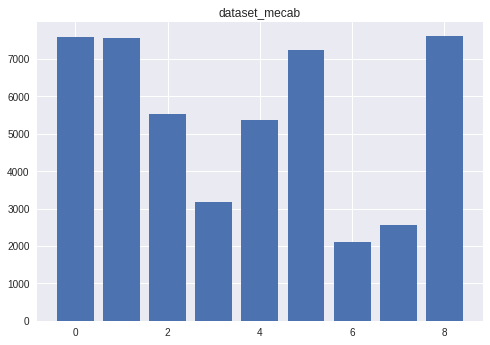

In [ ]:
# 클래스 분포 확인

import matplotlib.pyplot as plt

plt.style.use('seaborn')

dataset_mecab_vlcnt = dataset_mecab['emotion'].value_counts().reset_index()

plt.title('dataset_mecab')
plt.bar(dataset_mecab_vlcnt['index'], dataset_mecab_vlcnt['emotion'])

plt.show()

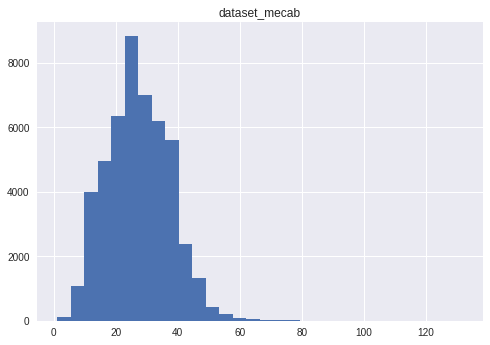

In [ ]:
# sentence 길이 분포 확인

import numpy as np

plt.style.use('seaborn')

dataset_mecab_len = [len(x) for x in dataset_mecab['sentence']]

plt.title('dataset_mecab')
plt.hist(dataset_mecab_len, bins=30)

plt.show()

In [ ]:
# 전처리 완료

dataset_mecab.to_csv('/gdrive/My Drive/KoBERT/data/data_mecab.csv', index=False)